[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/regularization.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Regularization

Regularization is an important technique used to prevent overfitting in machine learning models. This notebook shows different regularization approaches to reduce overfitting.

We use a modification and curated version of the [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) stored in `data/housing_curated.csv`.

In [1]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/regression'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

# import the required modules
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import pandas as pd

import utils

pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas
random_state = 42

## Dataset

Dataset meta information:

In [2]:
dataset_file_name = 'data/housing_curated.csv'
integer_independent_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
binary_independent_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea',
            'furnishingstatus_furnished','furnishingstatus_semi-furnished','furnishingstatus_unfurnished']
independent_vars = integer_independent_vars + binary_independent_vars
dependent_var = 'price'

### Load the dataset

Load the dataset and break it into training and testing sets.

In [3]:
# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.load_dataset_from_csv(dataset_file_name, independent_vars,
                                                                   dependent_var, 0.2, random_state)
print(f"Training set shape: {X_train.shape}.")
print("Training set description:\n", X_train.describe(), end='\n\n')

Training set shape: (439, 16).
Training set description:
          bedrooms   bathrooms     stories     parking       width      length  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     2.979499    1.289294    1.840547    0.678815   49.339408  119.840547   
std      0.732194    0.506261    0.882139    0.849003   12.407137   25.782938   
min      1.000000    1.000000    1.000000    0.000000   26.000000   70.000000   
25%      3.000000    1.000000    1.000000    0.000000   41.500000  102.000000   
50%      3.000000    1.000000    2.000000    0.000000   48.000000  117.000000   
75%      3.000000    2.000000    2.000000    1.000000   55.500000  136.000000   
max      6.000000    4.000000    4.000000    3.000000  183.000000  310.000000   

           quality    mainroad   guestroom    basement  hotwaterheating  \
count   439.000000  439.000000  439.000000  439.000000       439.000000   
mean   2165.685649    0.854214    0.182232    0.350797        

### Scale the dataset

Scale the dataset using the `RobustScaler` which is more robust to outliers.

In [4]:
# Scale the dataset
X_train_scaled, X_test_scaled = utils.scale_X_dataset(RobustScaler(), X_train, X_test)
# show the number of features
print(f"Training set shape: {X_train_scaled.shape}.")

Training set shape: (439, 16).


## Linear Regression Model

Train a linear regression model on the dataset and evaluate its performance.

Model performance with the original features:


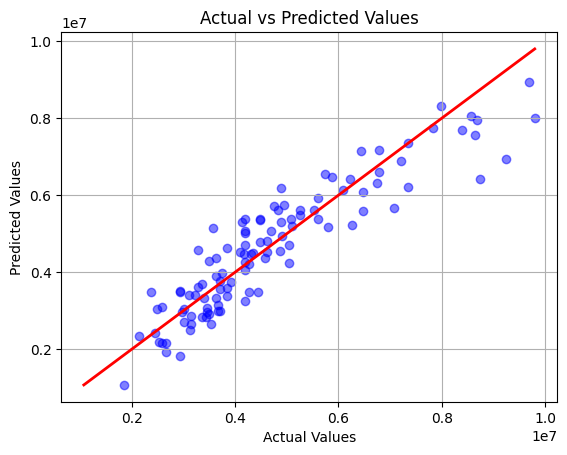

Mean Squared Error (MSE): 507668902357.6780
Root Mean Squared Error (RMSE): 712508.8788
Mean Absolute Error (MAE): 560334.4883
R-squared determination coefficient: 0.8396



In [5]:
print("Model performance with the original features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, random_state))

## Polynomial Regression Model

We now create a polynomial regression model, scale the new features, fit it to the dataset, and evaluate its performance.

Training set shape: (439, 968).
Model performance after adding the polynomial features:


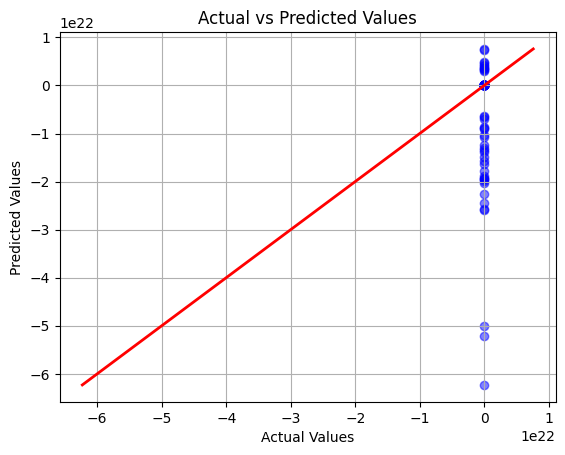

Mean Squared Error (MSE): 149351967041862919100148453389002742234611712.0000
Root Mean Squared Error (RMSE): 12220964243539169902592.0000
Mean Absolute Error (MAE): 5592439240384662470656.0000
R-squared determination coefficient: -47194194509950012198701888438272.0000



In [6]:
# Create the polynomial features with degree of 3
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# show the number of features
print(f"Training set shape: {X_train_poly.shape}.")
# Scale the dataset
X_train_scaled, X_test_scaled = utils.scale_X_dataset(RobustScaler(), X_train_poly, X_test_poly)
# evaluate the model
print("Model performance after adding the polynomial features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, random_state))

## ✨ Questions ✨

1. Does the model's performance improve after adding polynomial features?
2. Why?
3. How can we reduce overfitting?

### Answers

It does not improve at all, actually it gets worse.

 Now that the data has been scaled and the dimensions are greater, the model cannot 'focus' on whats really important to predict new values, because there are too many dimensions, making the model too complex and therefore overfitted.

 We can reduce overfitting by reducing the dimensions applying techniques like feature selection





## Feature Selection

Let's select the best features using the `SelectKBest` method and evaluate the model's performance. `SelectKBest` selects the top $k$ features based on a parameterizable score.

Model performance after adding the polynomial features and selecting the best 16 features:


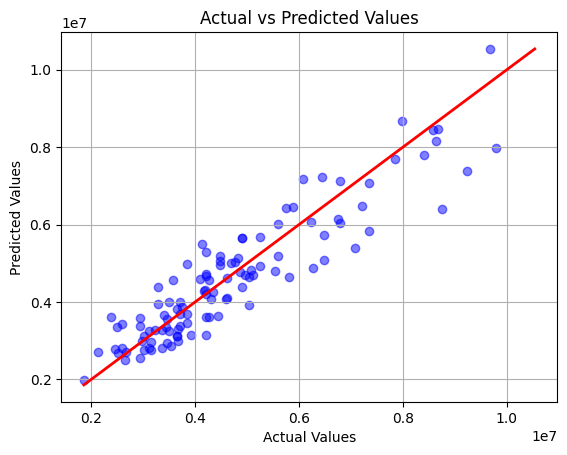

Mean Squared Error (MSE): 492685409256.6889
Root Mean Squared Error (RMSE): 701915.5286
Mean Absolute Error (MAE): 547731.8604
R-squared determination coefficient: 0.8443



In [7]:
# we want as many features as the original independent vars
features_to_select = len(independent_vars)
selector = SelectKBest(score_func=f_regression,  # the ANOVA statistic between the feature and the target
                       k=features_to_select)  # select same number as the original independent vars
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
# evaluate the model
print(f"Model performance after adding the polynomial features and selecting the best {features_to_select} features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, random_state))

## ✨ Questions ✨

4. Does the model's performance improve after selecting the best features? Why?
5. Is the performance better than the original linear model? Why?
6. What would you think it would happen if we halve the number of selected features? Do it!

### Answers
The model perfomance does increase since R-squared coefficient gets closer to 1, but its still closer to zero than closer to one. Also the rest of the metrics have decreased with respect to the linear and polynomial model ( withouth feature selection).


It has better performance since it has more complexity, and so the polynomial model has become closer to the problems actual complexity.



Model performance after adding the polynomial features and selecting the best 8 features:


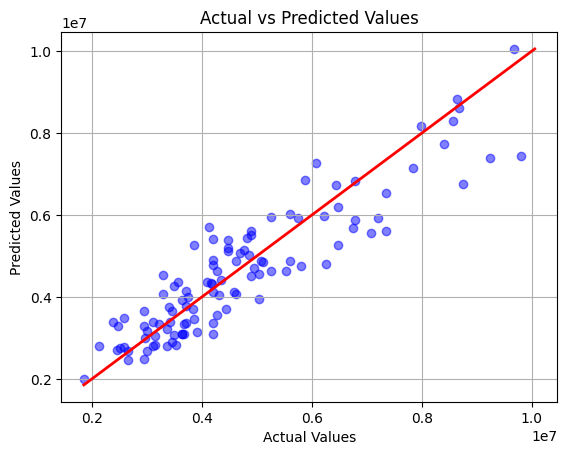

Mean Squared Error (MSE): 550988069262.7063
Root Mean Squared Error (RMSE): 742285.7060
Mean Absolute Error (MAE): 584670.4138
R-squared determination coefficient: 0.8259



In [8]:

# we want as many features as the original independent vars
features_to_select = int(len(independent_vars)/2)
#IN THIS PARTICULAR CASE THE BEST FEATURES ARE BEING SELECTED GIVEN THE NUMBER OF INDEPENDENT VARS.
#So , we halven that number of features.
selector = SelectKBest(score_func=f_regression,  # the ANOVA statistic between the feature and the target
                       k=features_to_select)  # select same number as the original independent vars
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
# evaluate the model
print(f"Model performance after adding the polynomial features and selecting the best {features_to_select} features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, random_state))

## ✨ Questions ✨

7. How do you think we could find the optimal number of features to select?


### Answers

Given r2 coefficient, the performance has worsen after halving the number of features to select.

We can find the optimal number using other techniques like L1,L2..


## L1 (Lasso) Regularization

Let's apply L1 regularization to polynomial features with all the features (we will use the `SGDRegressor` model with L1 regularization). We first select too many features on purpose to see the effect of L1 regularization.

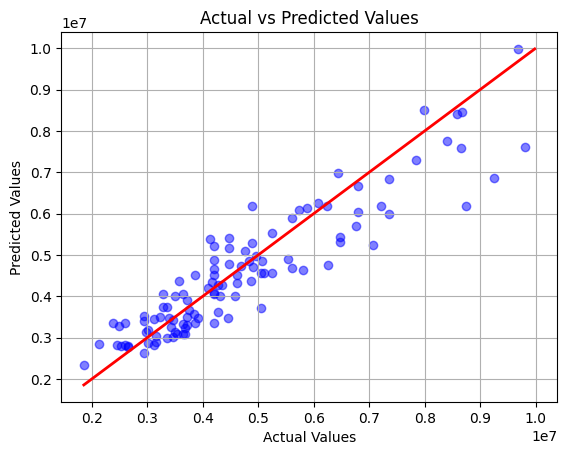

Model performance after adding the polynomial features and L1 regularization:
Mean Squared Error (MSE): 518704954140.2565
Root Mean Squared Error (RMSE): 720211.7426
Mean Absolute Error (MAE): 541944.1553
R-squared determination coefficient: 0.8361
Out of 80 to select, L1 (alpha=5000.0) has reduced them to 57.



In [9]:
# We first select lots of features on purpose to see the effect of L1 regularization
features_to_select = 5*len(independent_vars)  # Select 5 times the original independent vars
alpha = 5e3 # regularization parameter
selector = SelectKBest(score_func=f_regression, k=features_to_select)
X_train_many_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_many_selected = selector.transform(X_test_scaled)
model = SGDRegressor(penalty='l1', alpha=alpha, random_state=random_state)
model.fit(X_train_many_selected, y_train)
y_pred = model.predict(X_test_many_selected)
utils.plot_actual_vs_predicted_values(y_test, y_pred)
# Model evaluation
print(f"Model performance after adding the polynomial features and L1 regularization:")
metrics = utils.evaluate_regression(y_test, y_pred)
utils.show_regression_performance(*metrics, end='\n')
# print the number of features that have been reduced (the rest have been set to zero)
print(f"Out of {features_to_select} to select, L1 (alpha={alpha}) has reduced them to {len(model.coef_.nonzero()[0])}.\n")

## ✨ Questions ✨

8. What is the effect of L1 regularization?
9. What happens if we increase the alpha parameter (let's say to 1e50)? Try it!
10. What happens if we decrease the alpha parameter (let's say to 1e-5)? Try it!

### Answers

1- FEATURE SELECTION-> PUTS IRRELEVANT FEATURES TO 0
2- Overfitting
3 - Underfitting.  


## L2 (Ridge) + L1 (Lasso) Regularization = Elastic Net

By default, `SGDRegressor` uses L2 regularization. L2 regularization prevents coefficients from becoming too large, but it does not commonly reduce them to zero. Elastic Net combines L1 and L2 regularization. Thus, it can reduce the number of features and prevent coefficients from becoming too large.

Let's apply Elastic Net to the polynomial features with all the features

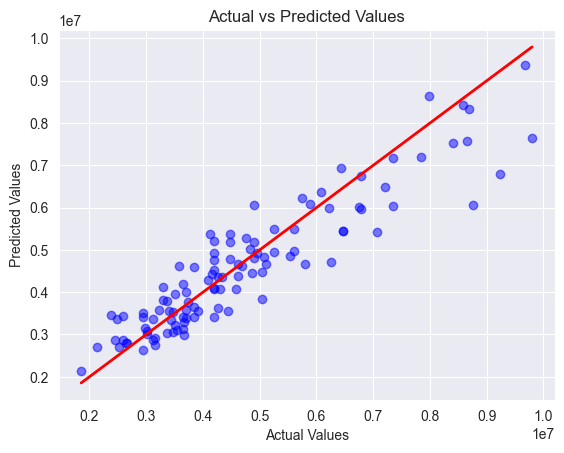

Model performance after adding the polynomial features and L1+L2 regularization:
Mean Squared Error (MSE): 506414333261.4423
Root Mean Squared Error (RMSE): 711627.9458
Mean Absolute Error (MAE): 528759.2625
R-squared determination coefficient: 0.8400
Out of 80 to select, L1+L2 (alpha=1) has reduced them to 80.


In [ ]:
features_to_select = 5*len(independent_vars)  # Select 5 times the original independent vars
alpha = 1  # regularization parameter
selector = SelectKBest(score_func=f_regression, k=features_to_select)
X_train_many_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_many_selected = selector.transform(X_test_scaled)
model = SGDRegressor(penalty='elasticnet',  # Elastic Net
                     alpha=alpha, l1_ratio=0.6, # L1 ratio of 0.6, l2_ratio of 0.4
                     random_state=random_state)
model.fit(X_train_many_selected, y_train)
y_pred = model.predict(X_test_many_selected)
utils.plot_actual_vs_predicted_values(y_test, y_pred)
# Model evaluation
print(f"Model performance after adding the polynomial features and L1+L2 regularization:")
metrics = utils.evaluate_regression(y_test, y_pred)
utils.show_regression_performance(*metrics, end='\n')
print(f"Out of {features_to_select} to select, L1+L2 (alpha={alpha}) has reduced "
      f"them to {len(model.coef_.nonzero()[0])}.\n")

## ✨ Questions ✨

11. Has the L1+L2 regularization improved the model's performance? Why?

### Answers

*Write your answers here.*